<a href="https://colab.research.google.com/github/YuukiHnf/GaussianProcess/blob/main/InducingGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import GPy
import torch
import numpy as np
import matplotlib.pyplot as plt

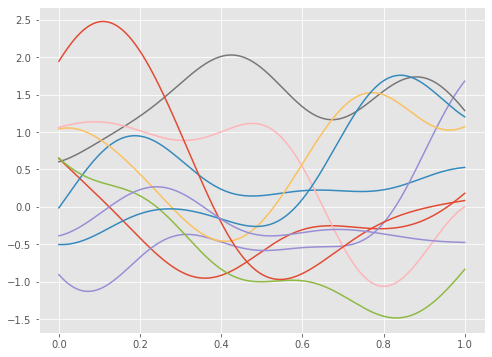

In [ ]:
plt.style.use('ggplot')
kernel = GPy.kern.RBF(1, variance=1.0, lengthscale=0.2)

N_sim = 1000
x = np.linspace(0,1,N_sim).reshape(-1,1)
K = kernel.K(x, x)

y_sim = np.random.multivariate_normal(np.zeros(shape=(N_sim)), K, size=20)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
for i in range(10):
  ax.plot(x, y_sim[i])

In [ ]:
import pandas as pd

data_pd = pd.read_csv("http://chasen.org/~daiti-m/gpbook/data/gpr.dat", sep='	',header=None)
print(data_pd)
data = np.array(data_pd)

     0    1
0 -0.5  0.7
1  0.5  1.8
2  1.0  1.7
3  1.4  2.3
4  3.0  1.0
5  2.3  0.0
6  2.5  0.2
7  1.5  2.0
8  1.1  2.4
9  0.7  1.5


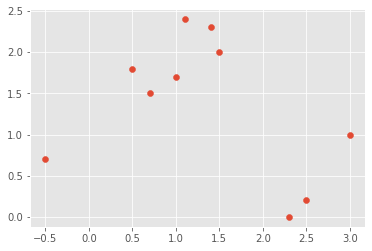

In [ ]:
plt.scatter(data[:,0], data[:,1])

In [ ]:
train_x = data[:,0].reshape(-1,1)
train_y = data[:,1].reshape(-1,1)

In [ ]:
kernel = GPy.kern.Matern52(input_dim=1, ARD=True)

model = GPy.models.GPRegression(train_x, train_y, kernel=kernel)
print(model)


Name : GP regression
Objective : 14.101262168807882
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  Mat52.variance           |    1.0  |      +ve      |        
  Mat52.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f24a40c2860>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f24a40c2c88>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f24a40c27b8>]]}

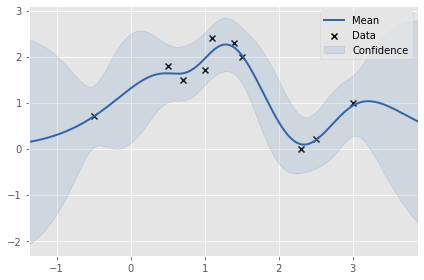

In [ ]:
model.optimize(messages=True)
model.plot()

reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.lengthscale
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f24a4023470>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f24a4023860>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f24a4023400>]]}

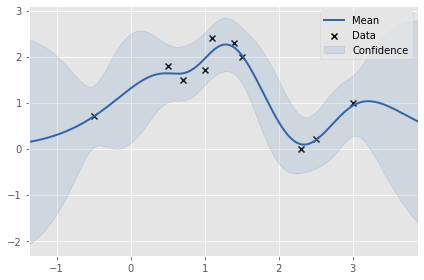

In [ ]:
model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
model.plot()

In [ ]:
hmc = GPy.inference.mcmc.HMC(model, stepsize=5e-2)
s = hmc.sample(num_samples=1000)

In [ ]:
print(model)


Name : GP regression
Objective : 19.99927434473544
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors   
  Mat52.variance           |   0.7683135722612747  |      +ve      |  Ga(0.1, 0.1)
  Mat52.lengthscale        |    0.768792301281411  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.17604867196524487  |      +ve      |  Ga(0.1, 0.1)


No handles with labels found to put in legend.


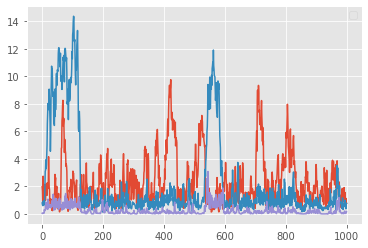

In [ ]:
plt.plot(s)
plt.legend()

In [ ]:
labels = ['kern variance', 'kern lengthscale','noise variance']
samples = s[300:] # cut out the burn-in period
from scipy import stats
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin, xmax, 100)

MCMCでサンプリングして、nonparametric手法でパラメータの事後分布推定

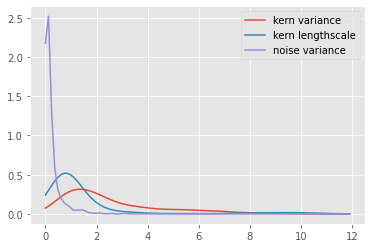

In [ ]:
for i in range(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plt.plot(xs,kernel(xs),label=labels[i])
plt.legend()

In [ ]:
print(model)


Name : GP regression
Objective : 19.99927434473544
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors   
  Mat52.variance           |   0.7683135722612747  |      +ve      |  Ga(0.1, 0.1)
  Mat52.lengthscale        |    0.768792301281411  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.17604867196524487  |      +ve      |  Ga(0.1, 0.1)


In [ ]:
model.kern.variance[:] = samples[:,0].mean()
model.kern.lengthscale[:] = samples[:, 1].mean()
model.likelihood.variance[:] = samples[:, 2].mean()
print(model)


Name : GP regression
Objective : 21.29306815015955
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors   
  Mat52.variance           |    2.533406824985835  |      +ve      |  Ga(0.1, 0.1)
  Mat52.lengthscale        |   1.4926685593664795  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.21923989797815138  |      +ve      |  Ga(0.1, 0.1)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f24a4a1cb70>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f24a3efcef0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f24a4a229e8>]]}

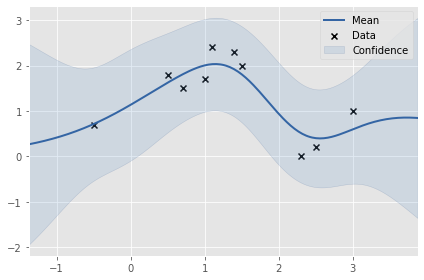

In [ ]:
model.plot()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(train_x)

In [ ]:
kernel = GPy.kern.Matern52(input_dim=1, ARD=True)

In [ ]:
sparse_model = GPy.models.SparseGPRegression(train_x, train_y, kernel=kernel,Z=kmeans.cluster_centers_)
print(sparse_model)


Name : sparse_gp
Objective : 14.101262166281662
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (10, 1)  |               |        
  Mat52.variance           |      1.0  |      +ve      |        
  Mat52.lengthscale        |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        


In [ ]:
sparse_model.parameter_names()

['inducing inputs',
 'Mat52.variance',
 'Mat52.lengthscale',
 'Gaussian_noise.variance']

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f249d4ee390>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f249d4ee780>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f249d4ee320>]],
 'inducing': <matplotlib.collections.PathCollection at 0x7f249d4e0fd0>}

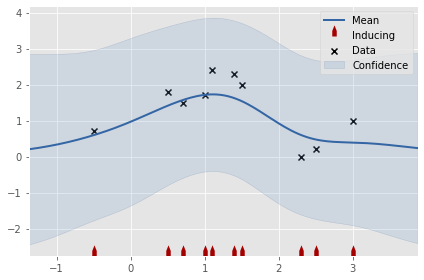

In [ ]:
sparse_model.plot()


Name : sparse_gp
Objective : 10.252509678777756
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |              (10, 1)  |               |        
  Mat52.variance           |   1.5531897700218265  |      +ve      |        
  Mat52.lengthscale        |    0.774914757051301  |      +ve      |        
  Gaussian_noise.variance  |  0.05922888073211034  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f249d46e198>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f249d4e0f60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f249d46e128>]],
 'inducing': <matplotlib.collections.PathCollection at 0x7f249d46ddd8>}

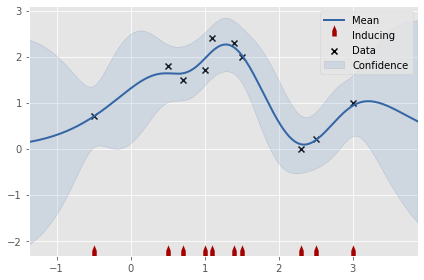

In [ ]:
sparse_model.optimize()
print(sparse_model)
sparse_model.plot()

In [ ]:
x1 = np.linspace(-2,2,120).reshape(-1,1)
x2 = np.linspace(-3,3,130).reshape(-1,1)
x1, x2 = np.array(np.meshgrid(x1,x2))
y = np.sin(x1*np.pi) + x2 + 0.01*np.random.multivariate_normal(np.zeros(shape=(120)),np.eye(120),size=(130))

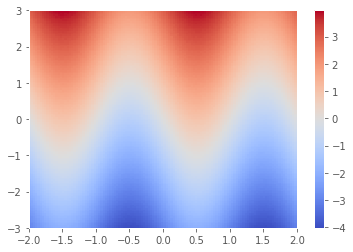

In [ ]:
import matplotlib.cm as cm
plt.pcolor(x1,x2,y, cmap=cm.coolwarm)
plt.colorbar()

In [ ]:
y.ravel().shape

(15600,)

In [ ]:
x1.shape

(130, 120)

In [ ]:
x1.ravel().shape

(15600,)

In [ ]:
X = np.hstack([x1.ravel().reshape(-1,1), x2.ravel().reshape(-1,1)]).reshape(-1,2)

In [ ]:
X.shape

(15600, 2)

In [ ]:
kernel2 = GPy.kern.GridRBF(input_dim=2)

grid_model = GPy.models.GPRegressionGrid(X, y.ravel().reshape(-1,1))
print(grid_model)

 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


IndexError: ignored